In [1]:
from pathlib import Path
import argparse
import os 
import numpy as np
# import pandas as pd
import math
from tqdm import tqdm
from PIL import Image, ImageDraw
from bs4 import BeautifulSoup
from imutils import paths

import threading

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # All optimization algos, SGD, Adam, etc
import torchvision.transforms as transforms # Transformations to perform on data set, in addition to obspy 
from torch.utils.data import DataLoader # For dataset management and to create mini batches
from pprint import pprint

import torchvision.datasets as datasets # Standard datasets to test out model

In [35]:
TRAIN_PATH = Path(r"C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\train")
IMAGE_PATHS = list(paths.list_images(TRAIN_PATH))
print(len(IMAGE_PATHS))
len(list(TRAIN_PATH.glob("*")))
# DATA_PATH = r"C:\Users\wilso\Desktop\ML-Earthquake-source-physics-research\src\data extraction\wilson\data_ISC"

1362


2710

In [36]:
# ### Rename files
# import glob
# import shutil
# import os

# TRAIN_PATH = Path(r"C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\train")
# IMAGE_PATHS = list(paths.list_images(TRAIN_PATH))
# print(len(IMAGE_PATHS))

# exist_pths = []
# count = 1
# dst_dir = r"C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\train"
# for idx, src_pth in enumerate(IMAGE_PATHS):
#     try:
#         ext = src_pth.rsplit(".")[-1]
#         xml_pth = src_pth.replace(ext, "xml")

#         os.rename(src_pth, os.path.join(dst_dir, str(count) + "." + ext))
#         os.rename(xml_pth, os.path.join(dst_dir, str(count) + ".xml"))
#     except:
#         print("[!ERROR]", src_pth)
#         exist_pths.append(src_pth)

#     if idx%100 == 0:
#         print(idx, "done")
#     count += 1

# print("Exist pth")
# for idx, src_pth in enumerate(exist_pths):
#     try:
#         ext = src_pth.rsplit(".")[-1]
#         xml_pth = src_pth.replace(ext, "xml")

#         os.rename(src_pth, os.path.join(dst_dir, str(count) + "." + ext))
#         os.rename(xml_pth, os.path.join(dst_dir, str(count) + ".xml"))
#     except:
#         print("[!ERROR]", src_pth)

#     if idx%100 == 0:
#         print(idx, "done")
#     count += 1

In [37]:
### Helper Functions ###
def read_xml(path):
    # load the annotation file, build the soup, and initialize our
    # list of ground-truth bounding boxes
    contents = open(path).read()
    soup = BeautifulSoup(contents, "html.parser")
    gtBoxes = []

    # extract the image dimensions
    w = int(soup.find("width").string)
    h = int(soup.find("height").string)

    # loop over all 'object' elements
    for o in soup.find_all("object"):
        # extract the label and bounding box coordinates
        label = o.find("name").string
        xMin = int(o.find("xmin").string)
        yMin = int(o.find("ymin").string)
        xMax = int(o.find("xmax").string)
        yMax = int(o.find("ymax").string)

        # truncate any bounding box coordinates that may fall
        # outside the boundaries of the image
        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(w, xMax)
        yMax = min(h, yMax)
        
        # update our list of ground-truth bounding boxes
        gtBoxes.append((xMin, yMin, xMax, yMax))
    return gtBoxes

In [38]:
# ### Display bbox ###
# image_path_sample_ls = IMAGE_PATHS[100:102]

# prev_img_class = ""
# for (i, image_path) in enumerate(image_path_sample_ls):
#     img_fname = image_path.split(os.path.sep)[-1]
#     img_fname = img_fname[:img_fname.rfind(".")]
#     img_class = image_path.split(os.path.sep)[-3]
#     if img_class != prev_img_class:
#         print(img_class) 
    
#     img_path = Path(os.path.join(TRAIN_PATH, img_class, "images", img_fname + ".jpg"))
#     bbox_path = Path(os.path.join(TRAIN_PATH, img_class, "annotations", img_fname + ".xml"))

#     img = Image.open(img_path) 
#     draw = ImageDraw.Draw(img)

#     bboxes = read_xml(bbox_path)
#     # The box contains the upper left corner (x, y) coordinates then width and height. 
#     # So we need to change these to (x1, y1) and (x2, y2) where they are the upper left and lower right corners 
#     for bbox in bboxes: 
#         x, y, w, h = bbox 
#         draw.rectangle(bbox, outline="red", width=3) 
#     img = img.resize((250, 250))
#     prev_img_class = img_class
#     display(img)

1362
C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\train\943.jpg


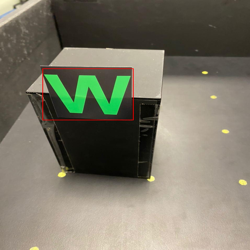

C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\train\944.jpg


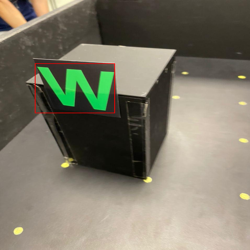

In [39]:
TRAIN_PATH = Path(r"C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\train")
IMAGE_PATHS = list(paths.list_images(TRAIN_PATH))

### Display bbox ###
print(len(IMAGE_PATHS))
image_path_sample_ls = IMAGE_PATHS[1300:1302]

prev_img_class = ""
for (i, image_path) in enumerate(image_path_sample_ls):
    img_fname = image_path.split(os.path.sep)[-1]
    img_fname = img_fname[:img_fname.rfind(".")]
#     img_class = image_path.split(os.path.sep)[-3]
#     if img_class != prev_img_class:
#         print(img_class) 

    ext = image_path.rsplit(".")[-1]
    img_path = Path(os.path.join(TRAIN_PATH, img_fname + "." + ext))
    bbox_path = Path(os.path.join(TRAIN_PATH, img_fname + ".xml"))

    img = Image.open(img_path) 
    draw = ImageDraw.Draw(img)

    bboxes = read_xml(bbox_path)
    # The box contains the upper left corner (x, y) coordinates then width and height. 
    # So we need to change these to (x1, y1) and (x2, y2) where they are the upper left and lower right corners 
    for bbox in bboxes: 
        x, y, w, h = bbox 
        draw.rectangle(bbox, outline="red", width=3) 
    img = img.resize((250, 250))
#     prev_img_class = img_class
    print(image_path)
    display(img)

In [40]:
### Config ###
IMG_SIZE = 256 # Using small image size to train faster, will try bigger images for better performance.

### Hyperparameters ###


# EfficientDet from [link](https://github.com/rwightman/efficientdet-pytorch)

In [41]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_train_efficientdet():
    # Get the model's config
    config = get_efficientdet_config("tf_efficientdet_d5")
    # Create the model
    net = EfficientDet(config, pretrained_backbone=False)
    # Load pretrained EfficientDet weights
    checkpoint = torch.load("path/to/weights")
    net.load_state_dict(checkpoint)
    # Change the number of classes to 1
    config.num_classes = 1
    config.image_size = 256
    # Add the head with the updated parameters
    head = HeadNet(
        config,
        num_outputs=config.num_classes,
        norm_kwargs=dict(eps=0.001, momentum=0.01),
    )
    # Attach the head
    net.class_net = head
    return DetBenchTrain(net, config)

In [42]:
from torch.utils.data import DataLoader, Dataset
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import pandas as pd
from pathlib import Path

def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=IMG_SIZE, width=IMG_SIZE, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=256, width=256, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )



def get_test_transforms():
    return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)




class MDPDataset(Dataset):

    def __init__(self, df = None, mode = "train", image_dir = "", transforms=None):
        super().__init__()
        if df is not None:
            self.df = df.copy()
            self.image_ids = df['image_id'].unique()
        else:
            # Test case
            self.df = None
            self.image_ids = [p.stem for p in Path(image_dir).glob("*.jpg")]
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        # Could be one or many rows.

        image = Image.open(f'{self.image_dir}/{image_id}.jpg').convert("RGB")
        # Convert to Numpy array
        image = np.array(image)
        image = image / 255.0
        image = image.astype(np.float32)


        if self.mode != "test":
    
            records = self.df[self.df['image_id'] == image_id]

            area = records["area"].values
            area = torch.as_tensor(area, dtype=torch.float32)

            boxes = records[["xmin", "ymin", "xmax", "ymax"]].values

            # there is only one class, so always 1.
            labels = torch.ones((records.shape[0],), dtype=torch.int64)
            
            # suppose all instances are not crowd.
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            # target['masks'] = None
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd
            # These are needed as well by the efficientdet model.
            target['img_size'] = torch.tensor([(IMG_SIZE, IMG_SIZE)])
            target['img_scale'] = torch.tensor([1.])
        
        else:

            # test dataset must have some values so that transforms work.
            target = {'cls': torch.as_tensor([[0]], dtype=torch.float32),
                      'bbox': torch.as_tensor([[0, 0, 0, 0]], dtype=torch.float32),
                      'img_size': torch.tensor([(IMG_SIZE, IMG_SIZE)]),
                      'img_scale': torch.tensor([1.])}


        if self.mode != "test":
            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                if len(sample['bboxes']) > 0:
                    # Apply some augmentation on the fly. 
                    sample = self.transforms(**sample)
                    image = sample['image']
                    boxes = sample['bboxes']
                    # Need yxyx format for EfficientDet.
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*boxes)))).permute(1, 0)

        else:
            sample = {
                'image': image,
                'bbox': target['bbox'],
                'cls': target['cls']
            }
            image = self.transforms(**sample)['image']

        return image, target

    def __len__(self) -> int:
        return len(self.image_ids)

In [44]:
# Some processing to add some metadata to the labels DataFrame
processed_train_labels_df = pd.read_csv(r"C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\csv\train.csv")

# train_labels_df['bbox'] = train_labels_df['bbox'].apply(eval)

# x = []
# y = []
# w = []
# h = []
# for bbox in train_labels_df['bbox']:
#     x.append(bbox[0])
#     y.append(bbox[1])
#     w.append(bbox[2])
#     h.append(bbox[3])
    
# processed_train_labels_df = train_labels_df.copy()
# processed_train_labels_df["x"] = x
# processed_train_labels_df["y"] = y
# processed_train_labels_df["w"] = w
# processed_train_labels_df["h"] = h


# processed_train_labels_df["area"] = processed_train_labels_df["w"] * processed_train_labels_df["h"]
# processed_train_labels_df["x2"] = processed_train_labels_df["x"] + processed_train_labels_df["w"]
# processed_train_labels_df["y2"] = processed_train_labels_df["y"] + processed_train_labels_df["h"]

# Create stratified folds, here using the source.
# This isn't the most optimal way to do it but I will leave it to you 
# to find a better one. ;)
from sklearn.model_selection import KFold
# skf = StratifiedKFold(n_splits=5)
kf = KFold(n_splits=2, random_state=None, shuffle=False)
for fold, (train_index, valid_index) in enumerate(kf.split(processed_train_labels_df["image_id"])):
    processed_train_labels_df.loc[valid_index, "fold"] = fold
processed_train_labels_df.sample(2).T
# We need to set a folder to get images
TRAIN_IMG_FOLDER = r"C:\Users\wilso\Desktop\MDP-Autonomous-Robot-Grp-33\RPI\Image-rec-EfficientDet\data\train"

# This is the transforms for the training phase
train_transforms = get_train_transforms()




train_dataset = MDPDataset(
    
    processed_train_labels_df, mode="train", image_dir=TRAIN_IMG_FOLDER, transforms=train_transforms
)

image, target = train_dataset[0]
print(image)
print(target)
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import pandas as pd
from pathlib import Path


def plot_image_with_bboxes(img_id, df):
    img_path = Path(TRAIN_IMG_FOLDER + f"/{img_id}.jpg")
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    bboxes = df.loc[lambda df: df["filename"] == img_id, "bbox"]
    # The box contains the upper left corner (x, y) coordinates then width and height.
    # So we need to change these to (x1, y1) and (x2, y2) where they are the upper 
    # left and lower right corners
    for bbox in bboxes:
        x, y, w, h = bbox
        transformed_bbox = [x, y, x + w, y + h]
        draw.rectangle(transformed_bbox, outline="red", width=3)
    return img



plot_image_with_bboxes("1", processed_train_labels_df)

OSError: [Errno 22] Invalid argument: 'C:\\Users\\wilso\\Desktop\\MDP-Autonomous-Robot-Grp-33\\RPI\\Image-rec-EfficientDet\\data\\train/C:\\Users\\wilso\\Desktop\\MDP-Autonomous-Robot-Grp-33\\RPI\\Image-rec-EfficientDet\\data\\train\\1.jpg'

In [ ]:
import torch
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet


def get_train_efficientdet():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = IMG_SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)
from pytorch_lightning import LightningModule

class MDPModel(LightningModule):
    
    def __init__(self, df, fold):
        super().__init__()
        self.df = df
        self.train_df = self.df.loc[lambda df: df["fold"] != fold]
        self.valid_df = self.df.loc[lambda df: df["fold"] == fold]
        self.image_dir = TRAIN_IMG_FOLDER
        self.model = get_train_efficientdet()
        self.num_workers = 4
        self.batch_size = 8
    
    
    def forward(self, image, target):
        return self.model(image, target)
    

# Create a model for one fold.
model = MDPModel(processed_train_labels_df, fold=0)
model
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

def collate_fn(batch):
    return tuple(zip(*batch))

# Let's add the train and validation data loaders.

def train_dataloader(self):
    train_transforms = get_train_transforms()
    train_dataset = MDPDataset(
        self.train_df, image_dir=self.image_dir, transforms=train_transforms
    )
    return DataLoader(
        train_dataset,
        batch_size=self.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        collate_fn=collate_fn,
        num_workers=self.num_workers,
    )

def val_dataloader(self):
    valid_transforms = get_train_transforms()
    valid_dataset = MDPDataset(
        self.valid_df, image_dir=self.image_dir, transforms=valid_transforms
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=self.batch_size,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=False,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=self.num_workers,
    )
    iou_types = ["bbox"]
    # Had to comment these since the evaluation doesn't work yet.
    # More on this in the next section.
    # coco = convert_to_coco_api(valid_dataset)
    # self.coco_evaluator = CocoEvaluator(coco, iou_types)
    return valid_dataloader



MDPModel.train_dataloader = train_dataloader
MDPModel.val_dataloader = val_dataloader
def training_step(self, batch, batch_idx):
    images, targets = batch
    targets = [{k: v for k, v in t.items()} for t in targets]
    # separate losses
    images = torch.stack(images).float()
    targets2 = {}
    targets2["bbox"] = [
        target["boxes"].float() for target in targets
    ]  # variable number of instances, so the entire structure can be forced to tensor
    targets2["cls"] = [target["labels"].float() for target in targets]
    targets2["image_id"] = torch.tensor(
        [target["image_id"] for target in targets]
    ).float()
    targets2["img_scale"] = torch.tensor(
        [target["img_scale"] for target in targets]
    ).float()
    targets2["img_size"] = torch.tensor(
        [(IMG_SIZE, IMG_SIZE) for target in targets]
    ).float()
    losses_dict = self.model(images, targets2)

    return {"loss": losses_dict["loss"], "log": losses_dict}

def validation_step(self, batch, batch_idx):
    images, targets = batch
    targets = [{k: v for k, v in t.items()} for t in targets]
    # separate losses
    images = torch.stack(images).float()
    targets2 = {}
    targets2["bbox"] = [
        target["boxes"].float() for target in targets
    ]  # variable number of instances, so the entire structure can be forced to tensor
    targets2["cls"] = [target["labels"].float() for target in targets]
    targets2["image_id"] = torch.tensor(
        [target["image_id"] for target in targets]
    ).float()
    targets2["img_scale"] = torch.tensor(
        [target["img_scale"] for target in targets], device="cuda"
    ).float()
    targets2["img_size"] = torch.tensor(
        [(IMG_SIZE, IMG_SIZE) for target in targets], device="cuda"
    ).float()
    losses_dict = self.model(images, targets2)
    loss_val = losses_dict["loss"]
    detections = losses_dict["detections"]
    # Back to xyxy format.
    detections[:, :, [1,0,3,2]] = detections[:, :, [0,1,2,3]]
    # xywh to xyxy => not necessary.
    # detections[:, :, 2] += detections[:, :, 0]
    # detections[:, :, 3] += detections[:, :, 1]

    res = {target["image_id"].item(): {
                'boxes': output[:, 0:4],
                'scores': output[:, 4],
                'labels': output[:, 5]}
            for target, output in zip(targets, detections)}
    # iou = self._calculate_iou(targets, res, IMG_SIZE)
    # iou = torch.as_tensor(iou)
    # self.coco_evaluator.update(res)
    return {"loss": loss_val, "log": losses_dict}

def validation_epoch_end(self, outputs):
    # self.coco_evaluator.accumulate()
    # self.coco_evaluator.summarize()
    # coco main metric
    # metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
    # metric = torch.as_tensor(metric)
    # tensorboard_logs = {"main_score": metric}
    # return {
    #     "val_loss": metric,
    #     "log": tensorboard_logs,
    #     "progress_bar": tensorboard_logs,
    # }
    pass

def configure_optimizers(self):
    return torch.optim.AdamW(self.model.parameters(), lr=1e-4)



MDPModel.training_step = training_step
# Had to comment these since the evaluation doesn't work yet. More on this 
# in the next section.
# MDPModel.validation_step = validation_step
# MDPModel.validation_epoch_end = validation_epoch_end
MDPModel.configure_optimizers = configure_optimizers

In [ ]:
from pytorch_lightning import Trainer, seed_everything, loggers

seed_everything(314)
# Create a model for one fold.
# As an exercise, try doing it for the other folds and chaning the Trainer. ;)
model = MDPModel(processed_train_labels_df, fold=0)
logger = loggers.TensorBoardLogger("logs", name="effdet-b5", version="fold_0")  
trainer = Trainer(gpus=1, logger=logger, fast_dev_run=True)
trainer.fit(model)
torch.save(model.model.state_dict(), "mdp_cv.pth")

In [ ]:
from effdet import DetBenchPredict


def get_test_efficientdet(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d1')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=IMG_SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, 
                            norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint, strict=False)
    net = DetBenchPredict(net, config)
    return net



def make_predictions(model, images, score_threshold=0.22):
    images = torch.stack(images).float()
    predictions = []
    targets = torch.tensor([1]*images.shape[0])
    img_scales = torch.tensor(
        [1 for target in targets]
    ).float()
    img_sizes = torch.tensor(
        [(IMG_SIZE, IMG_SIZE) for target in targets]
    ).float()
    with torch.no_grad():
        detections = model(images, img_scales, img_sizes)
        for i in range(images.shape[0]):
            pred = detections[i].detach().cpu().numpy()
            boxes = pred[:,:4]    
            scores = pred[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return predictions
TEST_IMG_FOLDER = "../input/global-MDP-detection/test"


test_model = get_test_efficientdet("mdp_cv.pth")

test_dataset = MDPDataset(
    
    None, mode="test", image_dir=TEST_IMG_FOLDER, transforms=get_test_transforms()
)

image, _ = test_dataset[0]

predictions = make_predictions(test_model, [image])
predictions

In [ ]:
# Hyperparameters
lr = 0.0002
batch_size = 64
image_size = 64 #
channels_img = 1
channels_noise = 256
num_epochs = 10

features_d = 16 # may want to set larger
features_g = 16 # may want to set larger

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")